# The Ifood test case
---
https://github.com/ifood/ifood-data-business-analyst-test \
This notebook goes into detail on how I approached this test case 

# First steps, performing EDA
---

Lets begin by importing and loading what we will need

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
initial_df = pd.read_csv('./ifood-data-business-analyst-test-master/ml_project1_data.csv', index_col=0)

Now let's take a peek on the dataframe we have

In [3]:
display(initial_df.head())
display(initial_df.sample(5))

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,...,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,...,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,...,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,5,0,0,0,0,0,0,3,11,0


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,
8605,1964,PhD,Together,46910.0,1,1,2014-03-23,36,48,0,...,6,0,0,0,0,0,0,3,11,0
7128,1977,PhD,Single,42997.0,1,1,2013-12-07,91,4,0,...,7,0,0,0,0,0,0,3,11,0
5154,1972,Master,Divorced,37760.0,1,0,2013-08-11,54,26,3,...,6,0,0,0,0,0,0,3,11,0
4939,1946,Graduation,Together,37760.0,0,0,2012-08-31,20,84,5,...,7,0,0,0,0,0,0,3,11,0
999,1991,Graduation,Single,86037.0,0,0,2013-01-02,95,490,44,...,3,0,1,1,0,0,0,3,11,1


Then lets see the types of data we are working with

In [4]:
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2240 entries, 5524 to 9405
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2240 non-null   int64  
 1   Education            2240 non-null   object 
 2   Marital_Status       2240 non-null   object 
 3   Income               2216 non-null   float64
 4   Kidhome              2240 non-null   int64  
 5   Teenhome             2240 non-null   int64  
 6   Dt_Customer          2240 non-null   object 
 7   Recency              2240 non-null   int64  
 8   MntWines             2240 non-null   int64  
 9   MntFruits            2240 non-null   int64  
 10  MntMeatProducts      2240 non-null   int64  
 11  MntFishProducts      2240 non-null   int64  
 12  MntSweetProducts     2240 non-null   int64  
 13  MntGoldProds         2240 non-null   int64  
 14  NumDealsPurchases    2240 non-null   int64  
 15  NumWebPurchases      2240 non-null 

Looks like most of the data that should be int is already typed as int, that's good, but now lets take a close at the 2 columns not described on the pdf

Z_CostContact always has 3 as the value, and Z_Revenue always has 11, on a hunch those are the cost of the campaing per user and the potential revenue per user but lets check

In [5]:
display(initial_df.Z_CostContact.sum())
display(initial_df[initial_df.Response == 1].Z_Revenue.sum())

6720

3674

On target, the values match the pdf info, but we wont need them for now, so for clarity and to start preprocessing already lets drop them

In [6]:
df = initial_df.drop(['Z_CostContact', 'Z_Revenue'],1)

Now lets start fixing the types on the non numeric columns

First the date one

In [7]:
df['Dt_Customer'] = pd.to_datetime(df.Dt_Customer)

Now let's check the str ones looking for categories

In [8]:
display(df.Education.value_counts())
df.Marital_Status.value_counts()

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64

Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64

Well both are delimited and categorical, we need to change the type

But before that let's fix the bogus user inputs that were not validated on the Marital_Status column, as there is only 7 of then we can check ourselves

In [9]:
invalid_status = ['Alone','YOLO','Absurd']
display(df.loc[df.Marital_Status.isin(invalid_status)])

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
ID,,,,,,,,,,,,,,,,,,,,,
433,1958,Master,Alone,61331.0,1,1,2013-03-10,42,534,5,...,1,6,8,0,0,0,0,0,0,0
7660,1973,PhD,Alone,35860.0,1,1,2014-05-19,37,15,0,...,1,2,5,1,0,0,0,0,0,1
92,1988,Graduation,Alone,34176.0,1,0,2014-05-12,12,5,7,...,0,4,6,0,0,0,0,0,0,0
7734,1993,Graduation,Absurd,79244.0,0,0,2012-12-19,58,471,102,...,10,7,1,0,0,1,1,0,0,1
4369,1957,Master,Absurd,65487.0,0,0,2014-01-10,48,240,67,...,5,6,2,0,0,0,0,0,0,0
492,1973,PhD,YOLO,48432.0,0,1,2012-10-18,3,322,3,...,1,6,8,0,0,0,0,0,0,0
11133,1973,PhD,YOLO,48432.0,0,1,2012-10-18,3,322,3,...,1,6,8,0,0,0,0,0,0,1


alone can be considered single \
Absurd can refer to the idea that asking the question is absurd so the Marital_Status cant be inferred \
now, the YOLO one looks suspicious, is it the same user with 2 IDs?

In [10]:
df.loc[11133] == df.loc[492]

Year_Birth              True
Education               True
Marital_Status          True
Income                  True
Kidhome                 True
Teenhome                True
Dt_Customer             True
Recency                 True
MntWines                True
MntFruits               True
MntMeatProducts         True
MntFishProducts         True
MntSweetProducts        True
MntGoldProds            True
NumDealsPurchases       True
NumWebPurchases         True
NumCatalogPurchases     True
NumStorePurchases       True
NumWebVisitsMonth       True
AcceptedCmp3            True
AcceptedCmp4            True
AcceptedCmp5            True
AcceptedCmp1            True
AcceptedCmp2            True
Complain                True
Response               False
dtype: bool

Well they are identical, but one accepted the Cmp6 and the other did not, to rly understand this we need more data, but for new lets just keep then as Not_Declared status

In [11]:
df.loc[df.Marital_Status == 'Alone', 'Marital_Status'] = 'Single'
df.loc[df.Marital_Status.isin(['YOLO', 'Absurd']), 'Marital_Status'] = 'Not_Declared'
df.Marital_Status.value_counts()

Married         864
Together        580
Single          483
Divorced        232
Widow            77
Not_Declared      4
Name: Marital_Status, dtype: int64

Now to set the right types, remembering that the Education is an ordered category, as a PhD is superior than a Master's degree, Master's deegre is superior to a bachelor's Graduation...

as it was not especified and I can't rly find those labels online, this is the pairing I made for the US education:

1. Basic: elementary/primary education
2. 2n Cycle: high school/secondary education
3. Graduation: Bachelor's degree
4. Master: Master's degree
5. PhD: PhD/Doctorate

In [12]:
df['Education'] = df.Education.astype('category')
df.Education.cat.reorder_categories(['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD'], ordered=True, inplace=True)
df['Marital_Status'] = df.Marital_Status.astype('category')

Now lets sanity check the numeric columns

In [13]:
df.describe()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
count,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,...,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,0.149107
std,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,...,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.356274
min,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,...,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,...,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,...,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,...,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Only the Income column looks suspicious, and as it's the only one with NaN values probably it was user input, this max value looks like a wrong input, let's take a look

In [14]:
df[df.Income > 150000]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
ID,,,,,,,,,,,,,,,,,,,,,
8475,1973,PhD,Married,157243.0,0,1,2014-03-01,98,20,2,...,22,0,0,0,0,0,0,0,0,0
1503,1976,PhD,Together,162397.0,1,1,2013-06-03,31,85,1,...,0,1,1,0,0,0,0,0,0,0
5555,1975,Graduation,Divorced,153924.0,0,0,2014-02-07,81,1,1,...,0,0,0,0,0,0,0,0,0,0
1501,1982,PhD,Married,160803.0,0,0,2012-08-04,21,55,16,...,28,1,0,0,0,0,0,0,0,0
5336,1971,Master,Together,157733.0,1,0,2013-06-04,37,39,1,...,0,1,1,0,0,0,0,0,0,0
4931,1977,Graduation,Together,157146.0,0,0,2013-04-29,13,1,0,...,28,0,1,0,0,0,0,0,0,0
11181,1949,PhD,Married,156924.0,0,0,2013-08-29,85,2,1,...,0,0,0,0,0,0,0,0,0,0
9432,1977,Graduation,Together,666666.0,1,0,2013-06-02,23,9,14,...,1,3,6,0,0,0,0,0,0,0


Well for sure it was a wrong input, lets fix this so we already treat this fake outlier

In [15]:
df.loc[9432, 'Income'] = np.NaN

Now we can begin finding correlations with our target variable

Let's plot the correlation matrix:

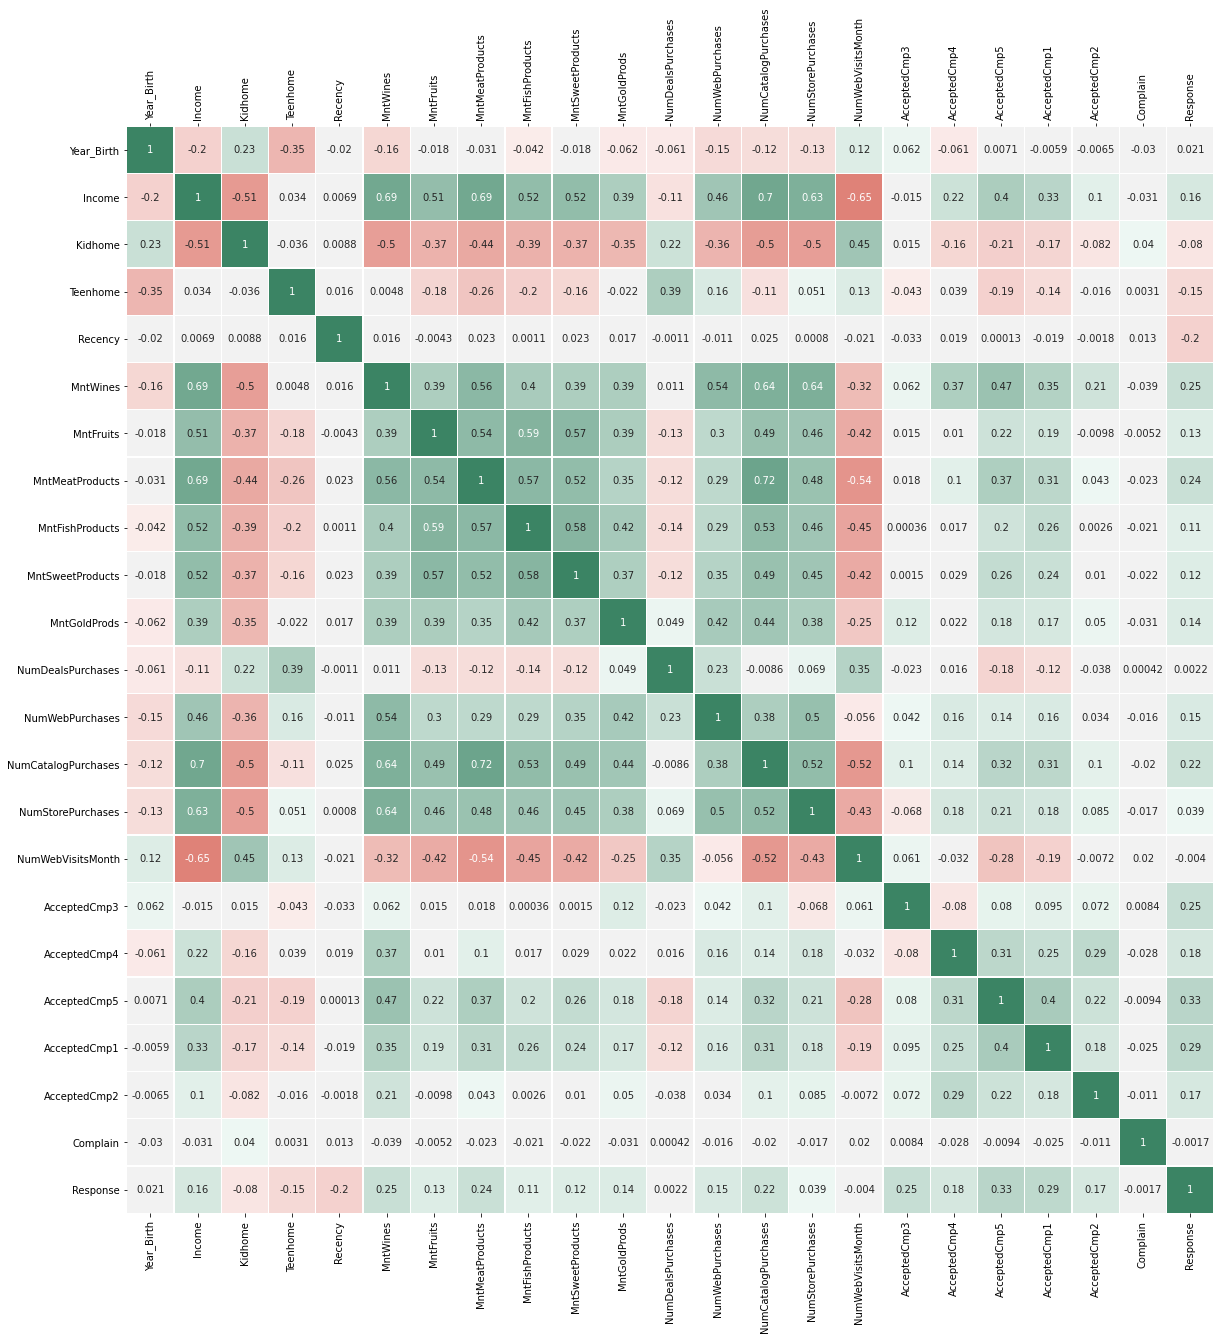

In [16]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(15, 150, center='light', n=200), square=True, yticklabels=1, annot=True, cbar=False, linewidths=.3, ax=ax)
ax.tick_params(top=True,labeltop=True)
plt.xticks(rotation='vertical')
plt.show()

Only some weak linear correlations, lets see the categorical ones now:

In [17]:
df.groupby('Education').Response.mean()

Education
Basic         0.037037
2n Cycle      0.108374
Graduation    0.134871
Master        0.154054
PhD           0.207819
Name: Response, dtype: float64

In [18]:
df.groupby('Marital_Status').Response.mean()

Marital_Status
Divorced        0.206897
Married         0.113426
Not_Declared    0.500000
Single          0.221532
Together        0.103448
Widow           0.246753
Name: Response, dtype: float64

The categorical gives us some good insights on who this campaing was targeting, lets take a closer look on the numeric ones now, beggining with Income:

In [19]:
print('<= 25%: ' + str(df[df.Income <= df.Income.describe()['25%']].Response.mean()))
print('25% -- 50%: ' + str(df[(df.Income >= df.Income.describe()['25%']) & (df.Income <= df.Income.describe()['50%'])].Response.mean()))
print('50% -- 75%: ' + str(df[(df.Income >= df.Income.describe()['50%']) & (df.Income <= df.Income.describe()['75%'])].Response.mean()))
print('> 75%: ' + str(df[df.Income > df.Income.describe()['75%']].Response.mean()))

<= 25%: 0.10469314079422383
25% -- 50%: 0.12454873646209386
50% -- 75%: 0.10270270270270271
> 75%: 0.2694394213381555


insights gathered:

- the campaign 6 was something loosely related to wine and meat focusing the high income users
- as I dont have the information if all 2.240 participed on the others campaings, I cant say for sure that c6 wanted to use the same market share of campaings 5 and 1, but i can say that they are at least loosely related
- at higher education levels the acceptance rate of Cmp6 is considerably higher but this can be inferred as an effect of the high positive correlation on income and education
- the campain was considerably better accepted better by users who are not on a relationship

In [20]:
df.to_csv('./processed_data/df.csv')

---

# First fit

Now lets try a quick first fit on a simple logistic regression classifier to understand better what we need to predict

First the check to see if we need to impute NaNs or deal with duplicates on this first test

In [21]:
display(df.shape[0])
display(df.dropna().drop_duplicates().shape[0])
ffdf = df.dropna().drop_duplicates().copy()

2240

2032

~10% of data loss, not that good, but not that bad too, lets start with handling the categorical columns for the model

In [22]:
ffdf['Education'] = ffdf.Education.cat.codes

In [23]:
ffdf = pd.get_dummies(ffdf)

In [24]:
ffdf['Dt_Customer'] = (pd.to_datetime('2020-11-07') - ffdf.Dt_Customer).dt.days

In [25]:
from sklearn.preprocessing import scale

In [26]:
y = ffdf.Response
X = ffdf.drop('Response', 1)
X = scale(X)

In [27]:
y.mean()

0.15354330708661418

a bit more than 15% representation on positive cases, the full dataset had 0.149107, for this first fit its acceptable, lets start

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.3, random_state= 345, stratify=y)

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
lg = LogisticRegression()

In [32]:
from sklearn.model_selection import cross_validate

In [33]:
aux = cross_validate(lg, X_train, y_train, cv=10, return_estimator=True)
lg = aux['estimator'][np.argmax(aux['test_score'])]

In [34]:
lg.score(X_train, y_train)

0.8895921237693389

In [35]:
lg.score(X_test, y_test)

0.8852459016393442

No overfitting, but a realy low accuracity score, a dumb classifier would get 85%

But accuracity is not what we look for on this problem, lets look a little deeper

In [36]:
y_pred = lg.predict(X_test)

In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
cf_m = confusion_matrix(y_test, y_pred)
pd.DataFrame(data= cf_m, columns=['pred_neg', 'pred_pos'], index= ['real_neg', 'real_pos'])

,pred_neg,pred_pos
real_neg,498,18
real_pos,52,42


Now, this is the data we need, as this is a profit maximization problem we need some datapoints, the fixed cost of the campaign, the cost of reach per user and the revenue per positive hit.

Unfortunately those data are obfuscated, but we can get an estimation
- the amount earned per positive hit is like we supposed the column Z_Revenue, 11 per user
- and the cost of reach per user is presented on Z_CostContact, 3 per user, and as the sum equals the 6.720 total cost of the campaign on the given pdf we see that the fixed cost is null or was dilluted, for simplicity's sake on this first fit we will take it as 0

quick note: As this is now a personal project, the MU, "Measurement Unit" presented on the pdf will be referred as space cash. 

So, lets begin dissecting it:

The profit:
- 42 true positives, each one represents a profit of 8 space cash, 11 of revenue - 3 of cost
- 18 false positives, each one is just 3 space cash deficit

The lost opportunity of profit:
- 52 false negatives, each represents the possiblity of 8 space cash not earned

so in the end we can get a metric of how well the model is doing by calculating a profit score of the current profit divided by the max profit possible:

In [39]:
def show_profit_metrics(cf_m):
    max_profit = (cf_m[1][0]+cf_m[1][1])*8
    current_profit = cf_m[1][1]*8 - cf_m[0][1]*3
    print('max profit = ' + str(max_profit))
    print('current profit = ' + str(current_profit))
    print('model profit score = ' + str(current_profit/max_profit))

In [40]:
show_profit_metrics(cf_m)

max profit = 752
current profit = 282
model profit score = 0.375


Well, not that good...

Its a positive score, but every space cash on the table is less space cash on the pocket, lets see how we can improve this logistic regression before jumping ship to another model

The first thing I did was checking the decision treshold, as it is the quick way to change some of the false negatives to true positives, and as the weight of converting them if 8 to 3 on the cost of new false positives, it's worth a shot.

lets start plotting the roc curve to get an idea

In [41]:
from sklearn.metrics import roc_curve

In [42]:
def plot_roc(fpr, tpr):
    '''Quick function to plot a roc_curve
    '''
    roc_fig, roc_ax = plt.subplots(figsize=(12,12), tight_layout = {'pad': 0})
    roc_curve_plot = sns.lineplot(fpr, tpr, ax=roc_ax, color='blue')
    roc_ax.set_ylabel('True Positive Rate')
    roc_ax.set_xlabel('False Positive Rate')
    return roc_fig, roc_ax

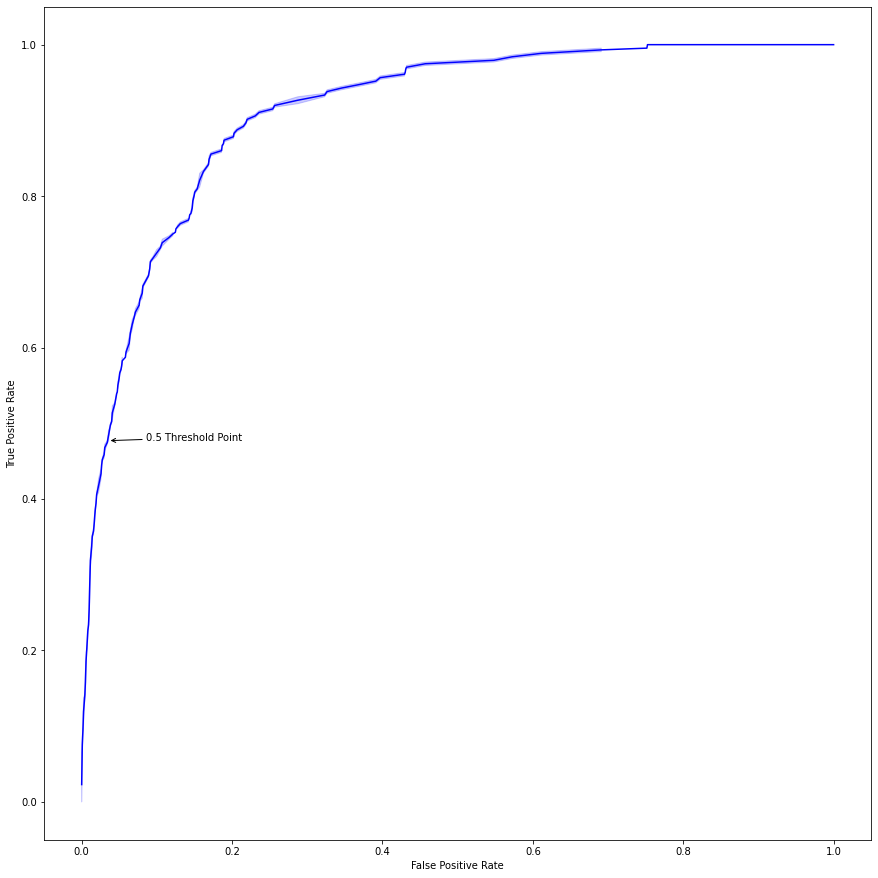

In [43]:
y_pred_proba = lg.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
lg_roc_fig, lg_roc_ax = plot_roc(fpr, tpr)

current_thresh_index = np.abs(thresholds - 0.5).argmin()
lg_roc_ax.annotate('0.5 Threshold Point',
                   xy=(fpr[current_thresh_index], tpr[current_thresh_index]), 
                   xytext=(fpr[current_thresh_index] + 0.05, tpr[current_thresh_index]),
                   arrowprops={'facecolor':'black', 'arrowstyle':'->'})

plt.close()
lg_roc_fig

Looks like a fine roc curve for quick trained linear regression, but now lets see what rly matters to define the threshold, the great profit line:

In [44]:
def add_profit_line(roc_fig, roc_ax, y):
    '''Quick function to plot the profit line on the roc graph, the profit line is defined by:
        Tpr = (Fpr * Total_neg * 3)/(Total_pos * 8)
        where:
        Tp = True positive rate
        Fpr = False positive rate
        Total_neg = Total number of negative responses on the set
        Total_pos = Total number of positive responses on the set    
    '''
    profit_line_x = np.array([0,0.48])
    profit_line_y = profit_line_x*((y.size - y.sum())*3/(y.sum()*8))

    profit_line = sns.lineplot(profit_line_x,profit_line_y,ax=roc_ax, color='green')
    roc_fig.legend(labels=['ROC', 'Profit Line'], loc=(0.8,0.2))

In [45]:
def add_distance_to_profit_line(roc_ax, point_x, point_y, dataset_y):
    profit_slope = ((dataset_y.size - dataset_y.sum())*3/(dataset_y.sum()*8))
    perpend_slope = -1/profit_slope
    current_y_intercept = point_y -(point_x*perpend_slope)
    profit_perpend_intercept = current_y_intercept/(profit_slope - perpend_slope)
    perpend_line_x = np.array([point_x,profit_perpend_intercept])
    perpend_line_y = perpend_line_x*perpend_slope + current_y_intercept
    perpend_line = sns.lineplot(perpend_line_x,perpend_line_y,ax=roc_ax, color='orange')

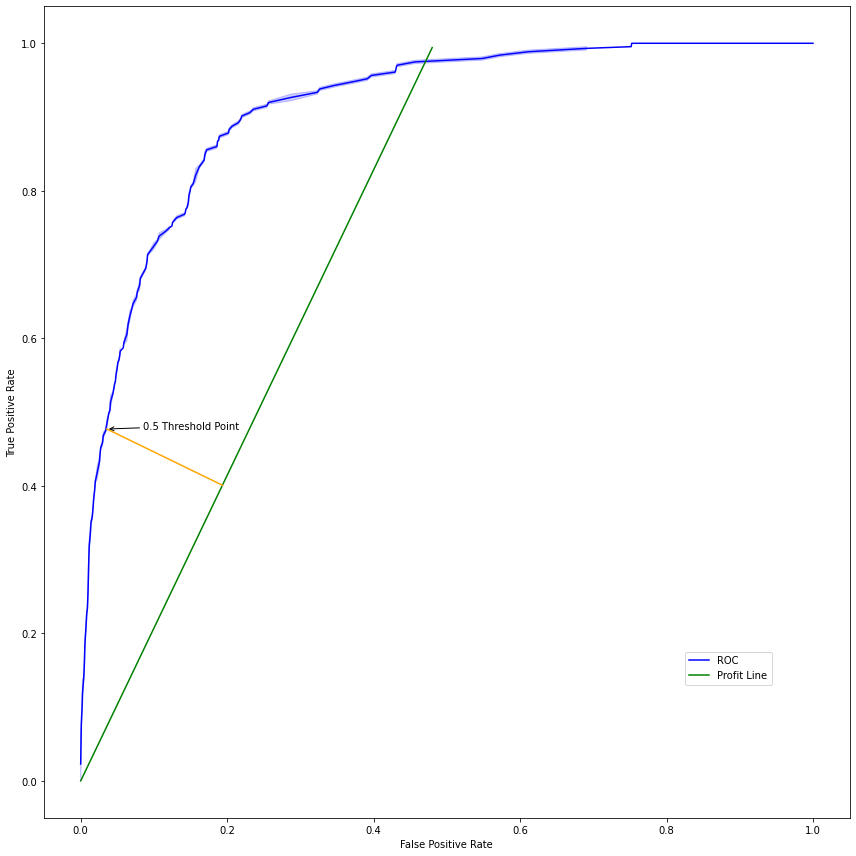

In [46]:
add_profit_line(lg_roc_fig, lg_roc_ax, y_train)

aux_x, aux_y = fpr[current_thresh_index], tpr[current_thresh_index]

add_distance_to_profit_line(lg_roc_ax, aux_x, aux_y, y_train)

lg_roc_fig

The green line, is what divides the threshold values who presents profit from those who dont, every point to the left is a profitable one.

Now what we are trying to maximize here is represented on this graph as the distance of the threshold point to the profit line (represented by the orange line), and we can see from the current threshold point, we cant get absurd gains from this model as it stands right now, but we can get a bit more

lets start getting the profit scores for every threshold:

In [47]:
def get_profit_score_by_threshold(clf, X, y, n=1000):
    '''put n as a parameter just bcs I felt the one calling the function should have control over it, even if I dont use it on this notebook
    '''
    y_pred_proba = clf.predict_proba(X)[:,1]
    decision_thresholds = [i/n for i in range(0,n+1)]
    dt_profit_scores = []
    for tresh in decision_thresholds:
        aux_y_pred = (y_pred_proba >= tresh).astype(int)
        aux_cf_m = confusion_matrix(y, aux_y_pred) 
        aux_profit_score = (aux_cf_m[1][1]*8 - aux_cf_m[0][1]*3)/(y.sum()*8)
        dt_profit_scores.append(aux_profit_score)
    return decision_thresholds, dt_profit_scores

In [48]:
decision_thresholds, dt_profit_scores = get_profit_score_by_threshold(lg, X_train, y_train)

In [49]:
lg_t_p_df = pd.DataFrame(index= decision_thresholds, data= {'profit_scores':dt_profit_scores})

In [50]:
lg_t_p_df_sorted = lg_t_p_df.sort_values('profit_scores', ascending=False)
display(lg_t_p_df_sorted.head(5))
display(lg_t_p_df_sorted[lg_t_p_df_sorted.index==0.5])

,profit_scores
0.276,0.524656
0.273,0.524083
0.251,0.522936
0.277,0.521789
0.242,0.521216


,profit_scores
0.5,0.403096


well, looks like we can get an 0.12 increase on the training set adjusting the treshold, lets now plot this value, so we can see it graphically

In [51]:
def plot_profit_thresh_from_df(t_p_df):
    t_p_fig, t_p_ax = plt.subplots(figsize=(12,6), tight_layout = {'pad': 0})
    t_p_df.plot(y='profit_scores', use_index=True, ax=t_p_ax)
    t_p_ax.set_ylim([0,1])
    t_p_ax.set_xlim([0,1])
    t_p_ax.set_ylabel('Profit Score')
    t_p_ax.set_xlabel('Threshold')
    return t_p_fig, t_p_ax

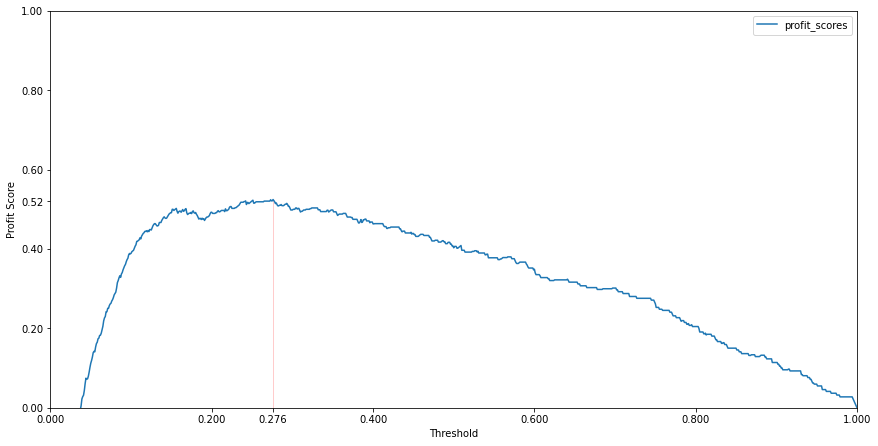

In [52]:
lg_t_p_fig, lg_t_p_ax = plot_profit_thresh_from_df(lg_t_p_df)
current_thresh_index = np.abs(thresholds - 0.276).argmin()
lg_t_p_ax.set_xticks([i/5 for i in range(6)] + [0.276])
lg_t_p_ax.set_yticks([i/5 for i in range(6)] + [0.52])
sns.lineplot([0.276,0.276], [0,0.524], color= 'red', ax= lg_t_p_ax)

plt.close()
lg_t_p_fig

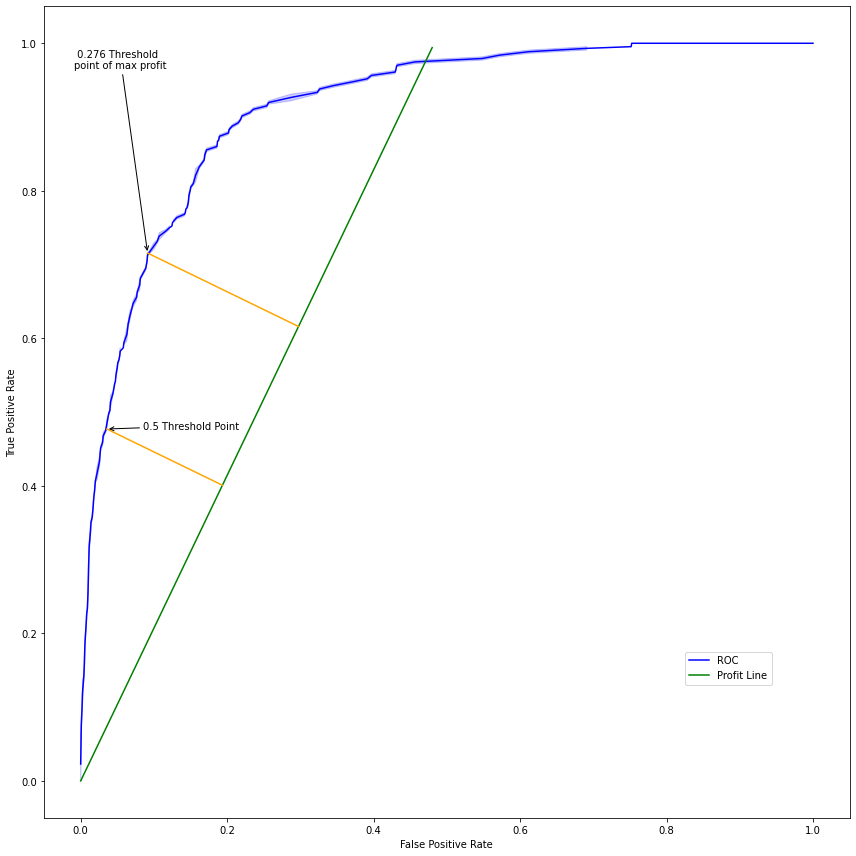

In [53]:
lg_roc_ax.annotate(' 0.276 Threshold\npoint of max profit',
                xy=(fpr[current_thresh_index], tpr[current_thresh_index]),
                xytext=(fpr[current_thresh_index]-0.1, tpr[current_thresh_index]+0.25),
                arrowprops={'facecolor':'black', 'arrowstyle':'->'})

aux_x, aux_y = fpr[current_thresh_index], tpr[current_thresh_index]

add_distance_to_profit_line(lg_roc_ax, aux_x, aux_y, y_train)

lg_roc_fig

And now that we got the best threshold on the train set lets see how it performs on unknown data:



In [54]:
best_threshold = lg_t_p_df['profit_scores'].idxmax()
y_pred = (lg.predict_proba(X_test)[:,1] >= best_threshold).astype(int)
cf_m = confusion_matrix(y_test, y_pred)
show_profit_metrics(cf_m)

max profit = 752
current profit = 292
model profit score = 0.3882978723404255


10 space bucks, a gain of 0.13 profit score, that was bad...

lets see what was the best threshold on the test set, and the max profit score with this model

In [55]:
decision_thresholds, test_dt_profit_scores = get_profit_score_by_threshold(lg, X_test, y_test)

In [56]:
test_lg_t_p_df = pd.DataFrame(index= decision_thresholds, data= {'profit_scores':test_dt_profit_scores})

In [57]:
test_lg_t_p_df_sorted = test_lg_t_p_df.sort_values('profit_scores', ascending=False)
display(test_lg_t_p_df_sorted.head(10))
display(test_lg_t_p_df[test_lg_t_p_df.index==0.5])
display(test_lg_t_p_df[test_lg_t_p_df.index==best_threshold])

,profit_scores
0.425,0.421543
0.424,0.421543
0.423,0.421543
0.422,0.421543
0.421,0.421543
0.372,0.417553
0.417,0.417553
0.415,0.417553
0.373,0.417553
0.416,0.417553


,profit_scores
0.5,0.375


,profit_scores
0.276,0.388298


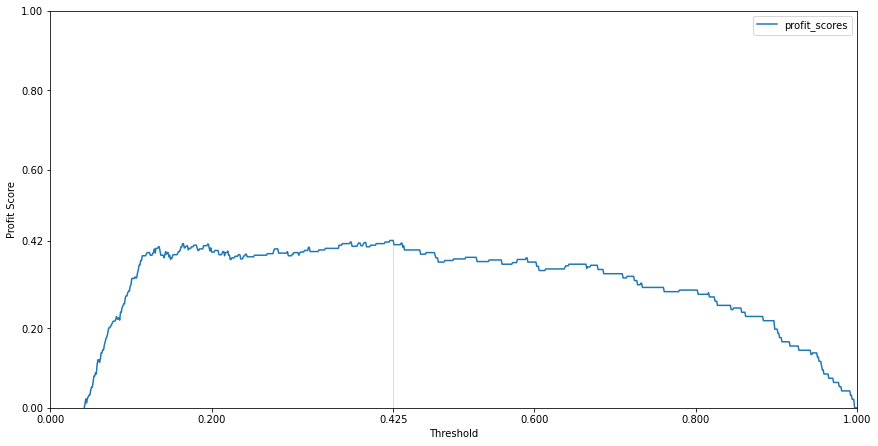

In [58]:
test_lg_t_p_fig, test_lg_t_p_ax = plot_profit_thresh_from_df(test_lg_t_p_df)
test_lg_t_p_ax.set_xticks([i/5 for i in range(6) if i!=2] + [0.425])
test_lg_t_p_ax.set_yticks([i/5 for i in range(6) if i!=2] + [0.42])
sns.lineplot([0.425,0.425], [0,0.42], color= 'red', ax= test_lg_t_p_ax)

plt.close()
test_lg_t_p_fig

0.42, but the graph is strange, it's a big plateau, this means that we cant rly gain much for this model right now changing only the threshold

so, lets change the model

the first parameter we can gain performance on is the classes weights, as we have a unbalanced dataset with a negative to positive rate of ~5.7 and our scoring function highly values positive predictions

First we can use the balanced setting sklearn provides us, this sets the weights to the inverse of the frequency:

In [59]:
abs_weights = y_train.size / (2 * np.bincount(y_train))
pd.DataFrame({'absolute_weights':abs_weights, 'proportional_weights':abs_weights/abs_weights.sum()}, index=[0,1])

,absolute_weights,proportional_weights
0,0.590532,0.153305
1,3.261468,0.846695


In [60]:
lg = LogisticRegression(class_weight = 'balanced')

In [61]:
aux = cross_validate(lg, X_train, y_train, cv=10, return_estimator=True)
lg = aux['estimator'][np.argmax(aux['test_score'])]

In [62]:
lg.score(X_train, y_train)

0.8368495077355836

In [63]:
lg.score(X_test, y_test)

0.8262295081967214

well again, the accuracy is bad, but looking at them we can see that the model does not seems to be overfitting

In [64]:
y_pred = lg.predict(X_test)

In [65]:
cf_m = confusion_matrix(y_test, y_pred)
pd.DataFrame(data= cf_m, columns=['pred_neg', 'pred_pos'], index= ['real_neg', 'real_pos'])

,pred_neg,pred_pos
real_neg,429,87
real_pos,19,75


In [66]:
show_profit_metrics(cf_m)

max profit = 752
current profit = 339
model profit score = 0.4507978723404255


wow, a raw 0.45 profit score on the test set looks promissing, lets plot the ROC and the profit line for a quick visual check

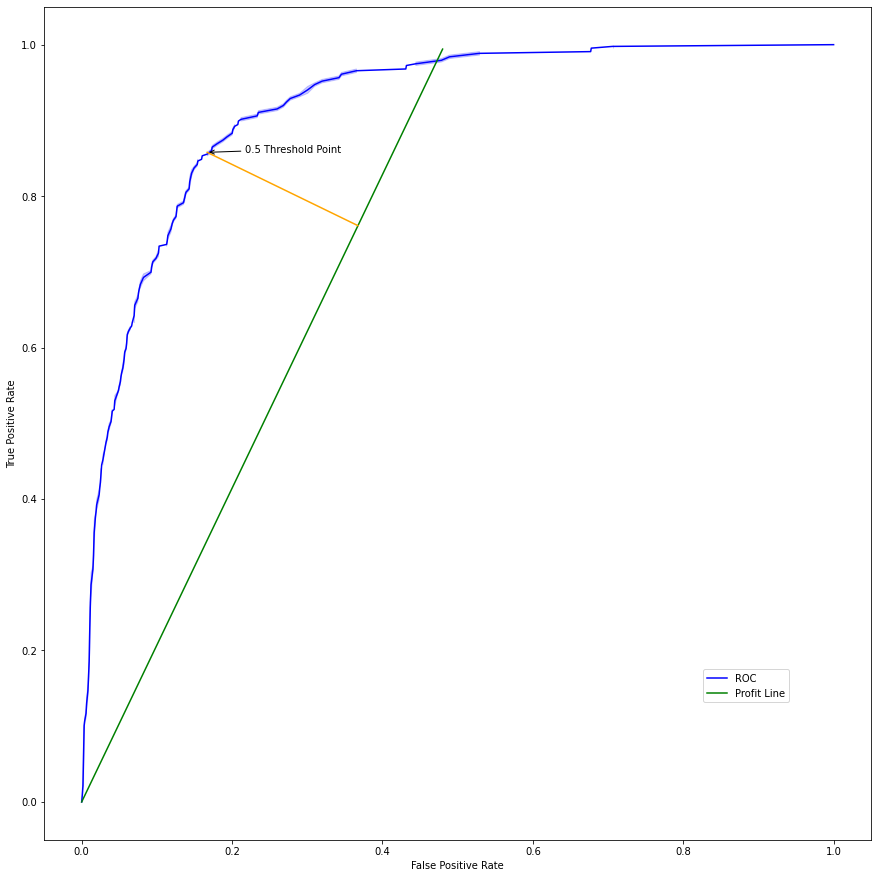

In [67]:
y_pred_proba = lg.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
lg_balanced_roc_fig, lg_balanced_roc_ax = plot_roc(fpr, tpr)

current_thresh_index = np.abs(thresholds - 0.5).argmin()
lg_balanced_roc_ax.annotate('0.5 Threshold Point',
                   xy=(fpr[current_thresh_index], tpr[current_thresh_index]), 
                   xytext=(fpr[current_thresh_index] + 0.05, tpr[current_thresh_index]),
                   arrowprops={'facecolor':'black', 'arrowstyle':'->'})

add_profit_line(lg_balanced_roc_fig, lg_balanced_roc_ax, y_train)

aux_x, aux_y = fpr[current_thresh_index], tpr[current_thresh_index]

add_distance_to_profit_line(lg_balanced_roc_ax, aux_x, aux_y, y_train)

plt.close()
lg_balanced_roc_fig

again, looks like we can get a bit more changing the threshold, but not much

In [68]:
decision_thresholds, dt_profit_scores = get_profit_score_by_threshold(lg, X_train, y_train)

In [69]:
lg_t_p_df = pd.DataFrame(index= decision_thresholds, data= {'profit_scores':dt_profit_scores})

In [70]:
lg_t_p_df_sorted = lg_t_p_df.sort_values('profit_scores', ascending=False)
display(lg_t_p_df_sorted.head(5))
display(lg_t_p_df_sorted[lg_t_p_df_sorted.index==0.5])

,profit_scores
0.529,0.530390
0.521,0.529817
0.525,0.528670
0.528,0.528670
0.527,0.528670


,profit_scores
0.5,0.512041


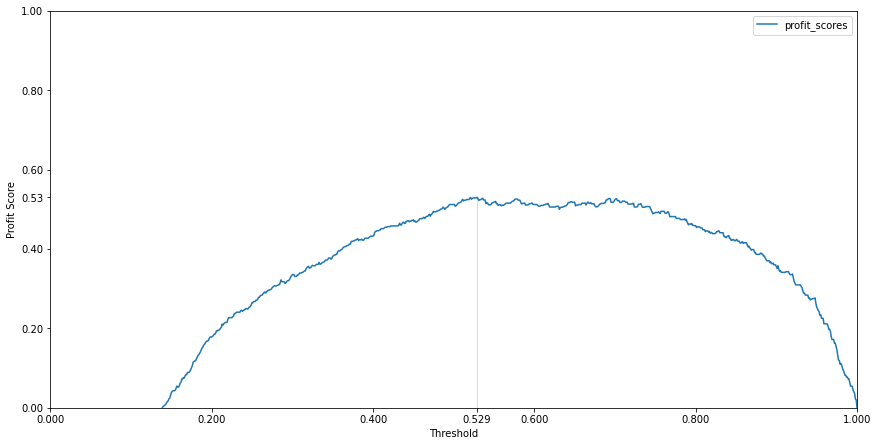

In [71]:
lg_t_p_fig, lg_t_p_ax = plot_profit_thresh_from_df(lg_t_p_df)
current_thresh_index = np.abs(thresholds - 0.276).argmin()
lg_t_p_ax.set_xticks([i/5 for i in range(6)] + [0.529])
lg_t_p_ax.set_yticks([i/5 for i in range(6)] + [0.53])
sns.lineplot([0.529,0.529], [0,0.53], color= 'red', ax= lg_t_p_ax)

plt.close()
lg_t_p_fig

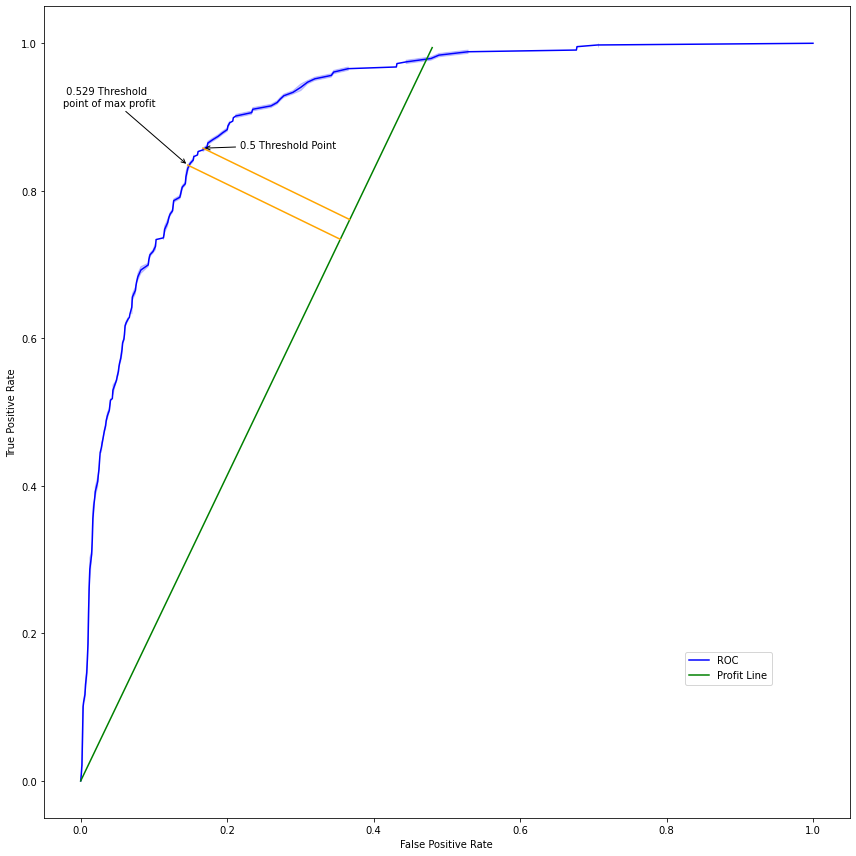

In [72]:
best_threshold = lg_t_p_df_sorted['profit_scores'].idxmax()
best_threshold_index = np.abs(thresholds - best_threshold).argmin()
lg_balanced_roc_ax.annotate(' 0.529 Threshold\npoint of max profit',
                xy=(fpr[best_threshold_index], tpr[best_threshold_index]),
                xytext=(fpr[best_threshold_index]-0.17, tpr[best_threshold_index]+0.08),
                arrowprops={'facecolor':'black', 'arrowstyle':'->'})
aux_x, aux_y = fpr[best_threshold_index], tpr[best_threshold_index]
add_distance_to_profit_line(lg_balanced_roc_ax, aux_x, aux_y, y_train)

lg_balanced_roc_fig

Well, 0.2 is a marginal gain, lets see if it translates well to the test set

In [73]:
y_pred = (lg.predict_proba(X_test)[:,1] >= best_threshold).astype(int)
cf_m = confusion_matrix(y_test, y_pred)
show_profit_metrics(cf_m)

max profit = 752
current profit = 345
model profit score = 0.4587765957446808


well, only a 0.8 increase, lets see what is the max this model could get on the test set

In [74]:
decision_thresholds, test_dt_profit_scores = get_profit_score_by_threshold(lg, X_test, y_test)

In [75]:
test_lg_t_p_df = pd.DataFrame(index= decision_thresholds, data= {'profit_scores':test_dt_profit_scores})

In [76]:
test_lg_t_p_df_sorted = test_lg_t_p_df.sort_values('profit_scores', ascending=False)
display(test_lg_t_p_df_sorted.head(10))
display(test_lg_t_p_df[test_lg_t_p_df.index==0.5])
display(test_lg_t_p_df[test_lg_t_p_df.index==best_threshold])

,profit_scores
0.547,0.468085
0.546,0.468085
0.548,0.468085
0.549,0.468085
0.550,0.468085
0.532,0.466755
0.544,0.464096
0.545,0.464096
0.556,0.461436
0.555,0.461436


,profit_scores
0.5,0.450798


,profit_scores
0.529,0.458777


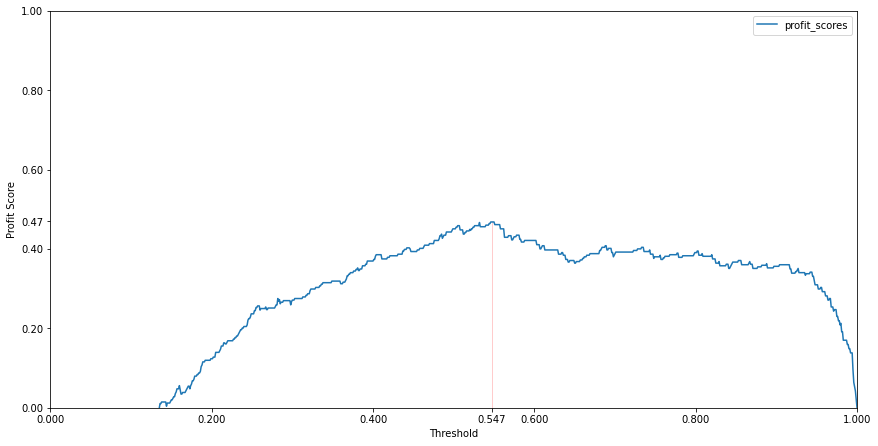

In [77]:
test_lg_t_p_fig, test_lg_t_p_ax = plot_profit_thresh_from_df(test_lg_t_p_df)
test_lg_t_p_ax.set_xticks([i/5 for i in range(6)] + [0.547])
test_lg_t_p_ax.set_yticks([i/5 for i in range(6)] + [0.47])
sns.lineplot([0.547,0.547], [0,0.47], color= 'red', ax= test_lg_t_p_ax)

plt.close()
test_lg_t_p_fig

the max is only 0.1 more, still, only 0.46 of the max profit, there must be a better model, lets just do a quick grid search to be sure and then we can try another algorithm

lets start defining the scoring function we will use

In [78]:
def profit_scorer(clf, X, y_truth)-> float:
    y_pred = clf.predict(X)
    tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
    return (tp*8 - fp*3)/(y_truth.sum()*8)

In [79]:
from sklearn.model_selection import GridSearchCV

In [80]:
gsLg = GridSearchCV(lg, {'class_weight':[{0:i/100, 1:1-(i/100)} for i in range(101)] + ['balanced']}, scoring= profit_scorer)

In [81]:
gsLg.fit(X_train, y_train)
display(gsLg.best_params_)

{'class_weight': {0: 0.22, 1: 0.78}}

In [82]:
lg = LogisticRegression(class_weight= {0: 0.22, 1: 0.78})

In [83]:
lg.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.22, 1: 0.78})

In [84]:
decision_thresholds, test_dt_profit_scores = get_profit_score_by_threshold(lg, X_test, y_test)

In [85]:
test_lg_t_p_df = pd.DataFrame(index= decision_thresholds, data= {'profit_scores':test_dt_profit_scores})

In [86]:
test_lg_t_p_df_sorted = test_lg_t_p_df.sort_values('profit_scores', ascending=False)
display(test_lg_t_p_df_sorted.head(10))
display(test_lg_t_p_df[test_lg_t_p_df.index==0.5])

,profit_scores
0.410,0.444149
0.409,0.444149
0.408,0.444149
0.407,0.444149
0.406,0.444149
0.405,0.444149
0.427,0.441489
0.403,0.440160
0.404,0.440160
0.350,0.438830


,profit_scores
0.5,0.408245


well, the best score on the test set of this new model is worse than our train driven score of the balanced model...

maybe if we introduce more samples to the gridSearch, it trains with less data than our balanced model as we didn't use cross validation and the grid search does
or we can change the classifier to use the threshold as a variable, to do that we need to create a new classifier class who inherits the methods from LinearRegression so we can override the predict method...

well, we can try

In [87]:
class ThreshLogisticRegression(LogisticRegression):
    def __init__(self, penalty='l2', *, dual=False, tol=1e-4, C=1.0,
                 fit_intercept=True, intercept_scaling=1, class_weight=None,
                 random_state=None, solver='lbfgs', max_iter=100,
                 multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
                 l1_ratio=None, threshold=0.5):
        
        super().__init__(penalty, dual=dual, tol=tol, C=C,
                 fit_intercept=fit_intercept, intercept_scaling=intercept_scaling, class_weight=class_weight,
                 random_state=random_state, solver=solver, max_iter=max_iter,
                 multi_class=multi_class, verbose=verbose, warm_start=warm_start, n_jobs=n_jobs,
                 l1_ratio=l1_ratio)
        
        self.threshold = threshold
        
    def predict(self, X):
        return self._old_predict(X) if self.threshold == 0.5 else (self.predict_proba(X)[:,1] >= self.threshold).astype(int)
    
    def _old_predict(self, X):
        scores = self.decision_function(X)
        if len(scores.shape) == 1:
            indices = (scores > 0).astype(np.int)
        else:
            indices = scores.argmax(axis=1)
        return self.classes_[indices]
        

So, the predict method uses the scores given by the decision function, as it's much faster, so changing the threshold there will not be the best

so lets just call it when the threshold is 0.5 and just use the predic_proba that we already got, not the best way, but the quick fix we need

In [88]:
lg0 = LogisticRegression()
lg1 = ThreshLogisticRegression()
lg2 = ThreshLogisticRegression(threshold= 0.0)
lg3 = ThreshLogisticRegression(threshold= 1.0)

In [89]:
lg0.fit(X_train, y_train)
lg1.fit(X_train, y_train)
lg2.fit(X_train, y_train)
lg3.fit(X_train, y_train)

print('number of values on test set: ' + str(len(y_test)))
print('unmodified: ' + str(lg.predict(X_test).sum()))
print('modified with threshold as 0.5: ' + str(lg1.predict(X_test).sum()))
print('modified with threshold as 0: ' + str(lg2.predict(X_test).sum()))
print('modified with threshold as 1: ' + str(lg3.predict(X_test).sum()))

number of values on test set: 610
unmodified: 63
modified with threshold as 0.5: 63
modified with threshold as 0: 610
modified with threshold as 1: 0


ok now that we have a way to change the threshold on the parameters, lets run gridsearch again

In [90]:
gsLg1 = GridSearchCV(lg1, {'class_weight':[{0:i/100, 1:1-(i/100)} for i in range(51)] + ['balanced'], 'threshold':[i/100 for i in range(10, 91)]},cv=10, scoring= profit_scorer, verbose=1, n_jobs=-1)

In [91]:
gsLg1.fit(X_train, y_train)

Fitting 10 folds for each of 4212 candidates, totalling 42120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1260 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 3260 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 6060 tasks      | elapsed:   27.7s


KeyboardInterrupt: 

In [ ]:
gsLg1.best_params_

In [ ]:
gsLg1.best_score_

In [ ]:
profit_scorer(gsLg1.best_estimator_, X_test, y_test)

well, i give up for now , maybe it's overfiing the train set now, looks like 0.458 is close to the max I can get with a logistic regression classifier without making changes to the dataset.

lets just quickly try a random forest classifier.

In [90]:
from sklearn.ensemble import RandomForestClassifier

In [93]:
rf = RandomForestClassifier()

In [94]:
aux = cross_validate(rf, X_train, y_train, cv=10, return_estimator=True, scoring= profit_scorer)
rf = aux['estimator'][np.argmax(aux['test_score'])]

In [95]:
rf.score(X_train, y_train)

0.9831223628691983

In [96]:
rf.score(X_test, y_test)

0.8622950819672132

well its for sure overfitting, lets just check the profit scores

In [99]:
profit_scorer(rf, X_train, y_train)

0.8985091743119266

In [100]:
profit_scorer(rf, X_test, y_test)

0.17952127659574468

well that is atrocius, lets try a quick grid search to fix the overfitting and get the best weights

In [231]:
gsRf = GridSearchCV(rf, {'n_estimators':[i*20 for i in range(7, 10)],
                         'max_depth':[i for i in range(4,7)] + [None],
                         'min_samples_leaf':[i for i in range(1,4)],
                         'max_features': ['auto','log2'],
                         'oob_score':[True, False],
                         'class_weight':['balanced', 'balanced_subsample'],
                         'min_impurity_decrease': [10**(-i) for i in range(5,10)] + [0]
                        }, scoring= profit_scorer, cv = 10, verbose=1, n_jobs=-1)

In [232]:
gsRf.fit(X_train, y_train)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 11242 tasks      |

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=5,
                                              min_impurity_decrease=5e-06,
                                              min_samples_leaf=2,
                                              n_estimators=160),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'max_depth': [4, 5, 6, None],
                         'max_features': ['auto', 'log2'],
                         'min_impurity_decrease': [1e-05, 1e-06, 1e-07, 1e-08,
                                                   1e-09, 0],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [140, 160, 180],
                         'oob_score': [True, False]},
             scoring=<function profit_scorer at 0x7f8f95cdb9d8>, verbose=1)

In [233]:
gsRf.best_params_

{'class_weight': 'balanced',
 'max_depth': 6,
 'max_features': 'auto',
 'min_impurity_decrease': 0,
 'min_samples_leaf': 2,
 'n_estimators': 140,
 'oob_score': True}

{'class_weight': 'balanced',
 'max_depth': 6,
 'max_features': 'auto',
 'min_impurity_decrease': 0,
 'min_samples_leaf': 2,
 'n_estimators': 140,
 'oob_score': True}

In [235]:
gsRf.best_score_

0.40354437229437223

In [237]:
rf = gsRf.best_estimator_

In [238]:
profit_scorer(rf, X_test, y_test)

0.324468085106383

In [276]:
rf = RandomForestClassifier(class_weight= 'balanced',
 max_depth= 6,
 max_features= 'auto',
 min_samples_leaf= 2,
 n_estimators= 140,
 oob_score= True,
 min_impurity_decrease = 0.000001)

aux = cross_validate(rf, X_train, y_train, cv=10, scoring= profit_scorer)
aux['test_score'].mean()

0.38828463203463204

In [278]:
rf.fit(X_train, y_train)
profit_scorer(rf, X_test, y_test)

0.3523936170212766

In [279]:
y_pred = rf.predict(X_test)
cf_m = confusion_matrix(y_test, y_pred)
pd.DataFrame(data= cf_m, columns=['pred_neg', 'pred_pos'], index= ['real_neg', 'real_pos'])

,pred_neg,pred_pos
real_neg,463,53
real_pos,41,53


In [280]:
decision_thresholds, dt_profit_scores = get_profit_score_by_threshold(rf, X_train, y_train)

In [281]:
rf_t_p_df = pd.DataFrame(index= decision_thresholds, data= {'profit_scores':dt_profit_scores})

In [282]:
rf_t_p_df_sorted = rf_t_p_df.sort_values('profit_scores', ascending=False)
display(rf_t_p_df_sorted.head(5))
display(rf_t_p_df_sorted[rf_t_p_df_sorted.index==0.5])

,profit_scores
0.496,0.804472
0.495,0.804472
0.494,0.802752
0.493,0.801032
0.489,0.800459


,profit_scores
0.5,0.795298


In [283]:
best_threshold = rf_t_p_df_sorted['profit_scores'].idxmax()

In [284]:
decision_thresholds, dt_profit_scores = get_profit_score_by_threshold(rf, X_test, y_test)

In [285]:
test_rf_t_p_df = pd.DataFrame(index= decision_thresholds, data= {'profit_scores':dt_profit_scores})

In [286]:
test_rf_t_p_df_sorted = test_rf_t_p_df.sort_values('profit_scores', ascending=False)
display(test_rf_t_p_df_sorted.head(5))
display(test_rf_t_p_df_sorted[test_rf_t_p_df_sorted.index==0.5])
display(test_rf_t_p_df_sorted[test_rf_t_p_df_sorted.index==best_threshold])

,profit_scores
0.513,0.375000
0.514,0.375000
0.515,0.375000
0.516,0.375000
0.512,0.371011


,profit_scores
0.5,0.352394


,profit_scores
0.496,0.344415


welp, still overfitting hard, but we got better results, the best course of action now would be to run a bigger grid search and then try some dimensionality reduction, cutting the less used features and leaving the 10-15 stronger ones, another time I will get back to this, and maybe we can get more than 0.46 of the max profit, maybe 0.9, I can dream, can't I?

In [336]:
lg = lg = ThreshLogisticRegression(class_weight= 'balanced', threshold= 0.529)
lg.fit(X_train, y_train)
feature_names = list(ffdf)
feature_names.remove('Response')
pd.DataFrame(data= {'coeficient':lg.coef_[0]}, index= feature_names).abs().sort_values('coeficient', ascending=False).head(15)

,coeficient
Recency,1.088205
Dt_Customer,1.055870
Teenhome,0.713156
NumStorePurchases,0.635327
Education,0.602831
AcceptedCmp5,0.521847
MntMeatProducts,0.494429
AcceptedCmp1,0.476818
AcceptedCmp3,0.459469
MntWines,0.395052


---

# Costumer segmentation

---